## Depression Severity Classification using DASS and Demographical Data

This notebook looks at modelling the severity of depression based on the scores given to the DAS assessment and certain demographical indicators.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, classification_report
from sklearn.pipeline import Pipeline
import pickle
from datetime import datetime

In [2]:
df = pd.read_csv("data/dass_data/data.csv", delimiter="\t")
print("Dataset Size:", df.shape)
df.head()

Dataset Size: (39775, 172)


,Q1A,Q1I,Q1E,Q2A,Q2I,Q2E,Q3A,Q3I,Q3E,Q4A,...,screensize,uniquenetworklocation,hand,religion,orientation,race,voted,married,familysize,major
0,4,28,3890,4,25,2122,2,16,1944,4,...,1,1,1,12,1,10,2,1,2,NaN
1,4,2,8118,1,36,2890,2,35,4777,3,...,2,1,2,7,0,70,2,1,4,NaN
2,3,7,5784,1,33,4373,4,41,3242,1,...,2,1,1,4,3,60,1,1,3,NaN
3,2,23,5081,3,11,6837,2,37,5521,1,...,2,1,2,4,5,70,2,1,5,biology
4,2,36,3215,2,13,7731,3,5,4156,4,...,2,2,3,10,1,10,2,1,4,Psychology


### Filter Out Columns and Check for Missing Values

This section creates the filters for the relevant columns, i.e for demography data and for the questions related to depression. The entire dataframe is then scanned to check for missing values. As seen below, the dataframe is relatively clean where most missing values only exist in the major column and requires analysis and preprocessing.

In [3]:
df_columns = df.columns

# http://www2.psy.unsw.edu.au/dass/Download%20files/Dass_template.pdf
# The question numbers are taken from the actual Dass template answering sheet.
# These questions specifically relate to depression and the scores given to these questions can classify the severity of depression.
depression_question_numbers = [3, 5, 10, 13, 16, 17, 21, 24, 26, 31, 34, 37, 38, 42]
demography_columns = ["education", "urban", "gender", "engnat", "age", "hand", "religion", "orientation", "race", "married", "familysize", "major"]
depression_question_columns = [f"Q{i}A" for i in depression_question_numbers]

nan_counts = df.isna().sum()
nan_counts[nan_counts > 0]

country        2
major      11403
dtype: int64

### Handling Missing and Inconsistent Values

The NaN values are replaced with the string "None" and treated as category 0. We see that even after replacing the NaN values, there are over 5000 unique values for the "major" column and by inspecting the counts for each unique value, there are actually duplicate majors with inconsistent spelling, abbreviations, etc. This column would hence need to be normalized before encoding.

In [4]:
df.fillna({"country":"None", "major":"None"}, inplace=True)
df["major"].value_counts()

None                  11425
English                1026
Psychology              850
Business                621
Accounting              607
                      ...  
Comp Science              1
Art and Education         1
Veterinary science        1
criminal law              1
computer sciece           1
Name: major, Length: 5309, dtype: int64

In [5]:
# Just by lowercasing and standardizing the possible ways of capitalisation, the number of unique majors drops to 4000
normalized_majors = df["major"].str.lower()
print(normalized_majors.value_counts()[:20])

none                      11446
psychology                 1440
english                    1242
engineering                 899
business                    820
accounting                  774
law                         670
computer science            545
medicine                    446
civil engineering           444
biology                     402
science                     397
psychology                  347
education                   346
nursing                     345
mechanical engineering      327
finance                     276
architecture                267
management                  249
medical                     248
Name: major, dtype: int64


In [6]:
def condition(title):
    if 'busin' in str(title).lower() or 'manage' in str(title).lower() or 'Buss' in str(title) or 'Bisness' in str(title) or 'Manag' in str(title) or 'buis' in str(title) or 'Entrepreneur' in str(title) or 'entrepr' in str(title).lower() or 'managment' in str(title).lower() or 'Buis' in str(title) or 'Busni' in str(title) or 'Mana' in str(title) or 'buss' in str(title).lower() or 'Bi' in str(title) or 'Mgt' in str(title) or 'MBA' in str(title) or 'Mgmt' in str(title) or 'MD' in str(title):
        return 'Business/Management'
    elif 'information technology' in str(title).lower() or 'IT' in str(title) or 'it' in str(title):
        return 'I.T'
    elif 'math' in str(title).lower() or 'LOGISTICS' in str(title) or 'st' in str(title).lower() or 'marh' in str(title).lower() or 'Mate' in str(title):
        return 'Mathematics'
    elif 'computer' in str(title).lower():
        return 'I.T'
    elif 'bio' in str(title).lower() or 'Plant' in str(title) or 'plant' in str(title).lower() or 'Micro' in str(title):
        return 'Biology'
    elif 'tesl' in str(title).lower() or 'TES' in str(title) or 'Teso' in str(title) or 'Enhlish' in str(title):
        return 'English'
    elif 'account' in str(title).lower() or 'Accoun' in str(title) or 'Acc' in str(title) or 'acc' in str(title).lower() or 'Acouunt' in str(title) or 'Acvount' in str(title) or 'Count' in str(title):
        return 'Accountacy'
    elif 'CA' in str(title):
        return 'CA'
    elif 'none' in str(title).lower() or '0' in str(title) or  '_' in str(title) or '.' in str(title) or 'Nine' in str(title) or '19' in str(title):
        return 'No Degree'
    elif 'nurs' in str(title).lower() or 'BSN' in str(title):
        return 'Nursing'
    elif '-' in str(title).lower() or 'NIL' in str(title):
        return 'No Degree'
    elif 'teach' in str(title).lower() or 'Lect' in str(title) or 'eet' in str(title).lower():
        return 'Teaching'
    elif 'pharma' in str(title).lower() or 'medic' in str(title).lower() or 'med' in str(title).lower() or 'hospi' in str(title).lower() or 'Mwdicine' in str(title) or 'Farmacy' in str(title) or 'Pharacology' in str(title) or 'farmasi' in str(title).lower() or 'Farmasy' in str(title):
        return 'Pharmacy/Medical'
    elif 'doctor' in str(title).lower() or  'MBBS' in str(title) or 'Mbbs' in str(title) or 'Surge' in str(title) or 'surge' in str(title) or 'mbbs' in str(title).lower()or 'dermat' in str(title).lower() or 'Podiat' in str(title) :
        return 'Doctor'
    elif 'no' in str(title).lower() or 'Undec' in str(title) or 'Idk' in str(title) or 'idk' in str(title).lower() or 'Hahaha' in str(title) or 'never' in str(title).lower() or 'T' in str(title) or 'Good' in str(title):
        return 'No Degree'
    elif 'film' in str(title).lower() or 'Cinema' in str(title) or 'fil' in str(title).lower() or 'Adver' in str(title) or 'adver' in str(title) or 'Act' in str(title) or 'Enter' in str(title) or 'digital' in str(title).lower() or 'cinema' in str(title).lower() or 'Video' in str(title) or 'Direct' in str(title) or 'Theat' in str(title) or 'Radio' in str(title) or 'theat' in str(title).lower() or 'drama' in str(title).lower():
        return 'Media'
    elif 'international' in str(title).lower() or 'Internatianal' in str(title):
        return 'International Relations'
    elif 'human' in str(title).lower() or 'hr' in str(title).lower() or 'Hs' in str(title) or 'Hm' in str(title) or 'Humam' in str(title):
        return 'Human Resources'
    elif 'art' in str(title).lower() or 'Painting' in str(title) or 'Drawing' in str(title) or 'ba' in str(title) or 'Printing' in str(title) or 'las' in str(title).lower() or 'Ma' in str(title) or 'paint' in str(title).lower() or 'creative' in str(title).lower() or 'AA' in str(title) or 'BA' in str(title):
        return 'Arts'
    elif 'islam' in str(title).lower() or 'Muamalat' in str(title) or 'Quran' in str(title) or 'Halal' in str(title) or 'Usul' in str(title) or 'Zakat' in str(title) or 'usul' in str(title).lower():
        return 'Islamic Studies'
    elif 'physio' in str(title).lower() or 'fis' in str(title).lower():
        return 'Physiotherapy'
    elif 'socio' in str(title).lower() or 'social' in str(title).lower() or 'soical' in str(title).lower() or 'Sis' in str(title) or 'Sosio' in str(title) or 'Sicio' in str(title) or 'sosiality' in str(title).lower():
        return 'Sociology'
    elif 'bank' in str(title).lower():
        return 'Banking'
    elif 'agri' in str(title).lower():
        return 'Agriculture'
    elif 'Market' in str(title) or 'Finan' in str(title) or 'finance' in str(title).lower() or 'MARKETING' in str(title) or 'market' in str(title).lower() or 'retail' in str(title).lower() or 'CMP' in str(title) or 'Merket' in str(title):
        return 'Marketing/Finance'
    elif 'counsel' in str(title).lower() or 'cauns' in str(title) or 'Kaunseling' in str(title) or 'kaunseling' in str(title) or 'Caunsel' in str(title):
        return 'Counselling'
    elif 'programming' in str(title).lower() or 'coding' in str(title).lower() or 'Ibm' in str(title) or 'ceit' in str(title) or 'Hacking' in str(title):
        return 'I.T'
    elif 'civil' in str(title).lower() or 'comp' in str(title).lower() or 'Mechanical' in str(title) or 'Electrical' in str(title) or 'Mechatronics' in str(title) or 'Eee' in str(title) or 'cs' in str(title).lower() or 'mecha' in str(title) or 'Chemical' in str(title) or 'chemical' in str(title) or 'tech' in str(title) or 'ec' in str(title).lower() or 'egineering' in str(title).lower() or 'manufacturing' in str(title).lower():
        return 'Engineering'
    elif 'ict' in str(title).lower() or 'developer' in str(title).lower() or 'I.T' in str(title) or 'CAE&D' in str(title) or 'It' in str(title):
        return 'I.T'
    elif 'commu' in str(title).lower() or 'comm' in str(title).lower() or 'com' in str(title).lower() or 'Conmunication' in str(title):
        return 'Communications'
    elif 'administration' in str(title).lower() or 'admin' in str(title).lower():
        return 'Administration'
    elif 'psycho' in str(title).lower() or 'psy' in str(title).lower() or 'Clinical osychology' in str(title) or 'hschology' in str(title) or 'Pysch' in str(title) or 'pys' in str(title).lower() or 'Pych' in str(title) or 'pscy' in str(title) or 'payc' in str(title).lower() or 'Phyc' in str(title) or 'psicologia' in str(title) or 'Phsychology' in str(title) or 'Phichology' in str(title) or 'psuchology' in str(title) or 'Pschology' in str(title) or 'psikologi' in str(title).lower():
        return 'Psychology'
    elif 'english' in str(title).lower() or 'Elglish' in str(title) or 'esl' in str(title).lower() or 'Emg' in str(title) or 'emglisj' in str(title).lower():
        return 'English'
    elif 'law' in str(title).lower() or 'BBA' in str(title) or 'llb' in str(title) or 'lew' in str(title).lower() or 'kaw' in str(title).lower() or 'enforcement' in str(title).lower() or 'Kaw' in str(title):
        return 'Law'
    elif 'engineering' in str(title).lower() or 'engi' in str(title).lower() or 'eng' in str(title).lower() or 'Software' in str(title) or 'soft' in str(title).lower() or 'mechanical' in str(title).lower() or 'Egineeering' in  str(title) or 'electronic' in str(title).lower() or 'CE' in str(title) or 'mech' in str(title).lower() or 'Ciclvil' in str(title) or 'Eggineering' in str(title) or 'Tech' in str(title) or 'Teol' in str(title) or 'EEE' in str(title) or 'PE' in str(title):
        return 'Engineering'
    elif 'architecture' in str(title).lower() or 'aechitecture' in str(title).lower() or 'archirecture' in str(title).lower() or 'architect' in str(title).lower() or 'Arsitechture' in str(title) or 'Building' in str(title) or 'building' in str(title).lower() or 'Arc' in str(title):
        return 'Architecture'
    elif 'design' in str(title).lower() or 'Desig' in str(title) or 'Dssign' in str(title):
        return 'Designer'
    elif 'science' in str(title).lower() or 'Sceince' in str(title) or 'Sci' in str(title) or 'sciene' in str(title) or 'BS' in str(title):
        return 'Pure Sciences'
    elif 'physics' in str(title).lower() or 'Phsyics' in str(title) or 'EMC' in str(title) or 'Physic' in str(title) or 'physi' in str(title):
        return 'Physics'
    elif 'chemistry' in str(title).lower() or 'CIS' in str(title) or 'Chem' in str(title):
        return 'Chemistry'
    elif 'french' in str(title).lower() or 'Fr' in str(title):
        return 'French'
    elif 'religi' in str(title).lower() or 'Relegion' in str(title) or 'Rel' in str(title) or 'Hukum' in str(title) or 'Sains' in str(title):
        return 'Religious Studies'
    elif title=='&#1593;&#1604;&#1605; &#1606;&#1601;&#1587;' or title=='&#22810;&#23186;&#39636;&#35373;&#35336;' or title=='nil' or title=='drop out' or title=='&#1055;&#1089;&#1080;&#1093;&#1086;&#1083;&#1' or title=='75' or title=='Secondary education' or title=='Thiê&#769;t kê&#769; &#273;ô&#768; ho&#803;a' or title=='18' or title=='ongoing' or title=='&#28888;&#22521;' or title=='lol' or title=='In college currently' or title=='secondary education' or title=='Dropped out' or title=='na' or title=='didnt attend' or title=='im going on the next year. ' or title=='&#304;lahiyat' or title=='lmfao, im 15' or title=='Elem Ed' or title=='yes' or title=='N/a' or title=='/' or title=='???' or title=='cocaine 101' or title=='doesnt matter' or title== 'oooo' or title=='G' or title=='Yes' or title=='Na' or title=='Na 'or title=='Want sure':
        return 'No Degree'
    elif 'Music' in str(title) or 'Dance' in str(title) or 'danc' in str(title).lower() or 'Vocational' in str(title) or 'Muisc' in str(title) or 'music' in str(title).lower() or 'Performance' in str(title):
        return 'Music/Dance'
    elif 'pol' in str(title).lower() or 'Govern' in str(title) or 'Right' in str(title):
        return 'Politics'
    elif 'photo' in str(title).lower() or 'Foto' in str(title) or 'Photo' in str(title):
        return 'Photography'
    elif 'Television' in str(title) or 'telev' in str(title).lower():
        return 'Television'
    elif 'bahasa' in str(title).lower() or 'Bahasa' in str(title) or 'Malay' in str(title) or 'malay' in str(title).lower():
        return 'Malaysian languages'
    elif 'Urban' in str(title) or 'Town' in str(title) or 'town' in str(title).lower() or 'planning' in str(title) or 'Plann' in str(title) or 'development' in str(title):
        return 'Economic Developments'
    elif 'Public' in str(title) or 'public' in str(title).lower():
        return 'Public Relations'
    elif 'Writing' in str(title) or 'writing' in str(title).lower() or 'Screenwritinf' in str(title) or 'Author' in str(title):
        return 'Writing/Author'
    elif 'philosophy' in str(title).lower() or 'Phil' in str(title) or 'philos' in str(title).lower() or 'Filo' in str(title) or 'Phylosophy' in str(title):
        return 'Philosophy'
    elif 'Actua' in str(title):
        return 'Acturial Studies'
    elif 'DENTALWORKS' in str(title) or 'dental' in str(title) or 'Dental' in str(title) or 'Odont' in str(title):
        return 'Dentist'
    elif 'beaut' in str(title).lower() or 'Fashion' in str(title) or 'make' in str(title) or 'fashion' in str(title).lower() or 'hair' in str(title).lower() or 'cosmet' in str(title).lower():
        return 'Fashion'
    elif 'Health' in str(title) or 'health' in str(title).lower() or 'wellness' in str(title).lower() or 'Healtcare' in str(title):
        return 'Healthcare'
    elif 'Language' in str(title) or 'lang' in str(title).lower() or 'Laq' in str(title):
        return 'Languages'
    elif 'cook' in str(title).lower() or 'bakery' in str(title).lower() or 'Bak' in str(title) or 'CULINARY' in str(title) or 'Food' in str(title) or 'food' in str(title) or 'chef' in str(title).lower() or 'Cul' in str(title) or 'Patiss' in str(title) or 'culi' in str(title).lower():
        return 'Cookings'
    elif 'Hotel' in str(title) or 'hotel' in str(title).lower() or 'food service' in str(title) or 'cater' in str(title).lower():
        return 'Hotel Management'
    elif 'therapy' in str(title).lower() or 'ot' in str(title).lower() or 'theraphy' in str(title):
        return 'Therapeutical Studies'
    elif 'veter' in str(title).lower() or 'Veter' in str(title) or 'Vet' in str(title):
        return 'Veterinary'
    elif 'Survey' in str(title) or 'survey' in str(title) or 'serveyors' in str(title).lower() or 'Qs' in str(title) or 'SURVEYING' in str(title) or 'QS' in str(title) or 'Surver' in str(title):
        return 'Surveyour Studies'
    elif 'Aircraft' in str(title) or 'aircraft' in str(title).lower() or 'aircr' in str(title).lower() or 'aviation' in str(title).lower() or 'Aero' in str(title) or 'navigation' in str(title).lower():
        return 'Aircrafts'
    elif 'environment' in str(title).lower() or 'Environment' in str(title) or 'envi' in str(title).lower():
        return 'Environmental Educations'
    elif 'Syariah' in str(title) or 'syariah' in str(title):
        return 'Syrian Languages'
    elif 'judicial' in str(title).lower() or 'juri' in str(title).lower() or 'legal' in str(title).lower():
        return 'Judicial Studies'
    elif 'Liter' in str(title) or 'literature' in str(title) or 'litt' in str(title).lower():
        return 'Literature'
    elif 'child' in str(title).lower() or 'Child' in str(title) or 'Preschool' in str(title):
        return 'Child Educations'
    elif 'Tour' in str(title) or 'tour'  in str(title).lower():
        return 'Tourisms'
    elif 'Gam' in str(title) or 'game' in str(title).lower():
        return 'Gaming'
    elif 'education' in str(title).lower() or 'Education' in str(title) or 'ed' in str(title).lower() or 'acad' in str(title) or 'Dploma' in str(title):
        return 'B.Ed or M.Ed'
    elif 'Sport' in str(title) or 'sport' in str(title).lower():
        return 'Sports'
    elif 'Petro' in str(title):
        return 'Petroleum'
    elif 'Journ' in str(title) or 'jour' in str(title).lower() or 'Joun' in str(title) or 'Jurn' in str(title):
        return 'Journalism'
    elif 'Mandarin' in str(title):
        return 'Chinese/Mandarin Languages'
    elif 'Electrician' in str(title):
        return 'Electrician'
    elif 'Network' in str(title) or 'network' in str(title).lower():
        return 'Networking'
    elif 'geo' in str(title).lower() or 'GEO' in str(title):
        return 'Geography'
    elif 'Librarian' in str(title) or 'lib' in str(title).lower():
        return 'Librarian'
    elif 'Mission' in str(title) or 'mission' in str(title).lower():
        return 'Missionary Studies'
    elif 'Forensic' in str(title) or 'foren' in str(title).lower() or 'Crime' in str(title) or 'crim' in str(title).lower():
        return 'Forensic/Criminal studies'
    elif 'Animation' in str(title) or 'animation' in str(title).lower() or 'imag' in str(title) or 'graphic' in str(title) or 'Graphic' in str(title):
        return 'Animations'
    elif 'aqua' in str(title).lower() or 'Aqu' in str(title):
        return 'Aquaculture'
    elif 'soldier' in str(title).lower() or 'lwa' in str(title).lower() or 'defence' in str(title):
        return 'Army'
    elif 'Kinesi' in str(title) or 'kines' in str(title).lower() or 'hod' in str(title):
        return 'Human Kinetics'
    elif 'Horti' in str(title) or 'horti' in str(title) or 'Landscape' in str(title):
        return 'Horticulture'
    elif 'commerce' in str(title).lower() or 'Coome' in str(title):
        return 'Commerce'
    elif 'Speech' in str(title) or 'speech' in str(title).lower():
        return 'Speech Pathology'
    elif 'SECRET' in str(title) or 'secret' in str(title).lower():
        return 'Secretary'
    elif 'Animals' in str(title) or 'animal' in str(title).lower() or 'Pet' in str(title):
        return 'Animal Care'
    elif 'Organisation' in str(title) or 'organi' in str(title).lower():
        return 'Organizational Behaviour'
    elif 'event' in str(title).lower() or 'Event' in str(title):
        return 'Event Managment'
    elif 'radiology' in str(title).lower() or 'Radiography' in str(title) or 'radiograpghy' in str(title).lower() or 'Radiation' in str(title) or 'radiography' in str(title):
        return 'Radiography'
    elif 'nutrition' in str(title).lower() or 'Nutrition' in str(title):
        return 'Nutritionist'
    elif 'Audit' in str(title) or 'audit' in str(title).lower():
        return 'Auditing'
    elif 'Neuro' in str(title) or 'neuroligy' in str(title).lower():
        return 'Neurology'
    elif 'Anato' in str(title) or 'anat' in str(title).lower():
        return 'Anatomy'
    elif 'trade' in str(title).lower():
        return 'Trading'
    elif 'Interpre' in str(title) or 'translation' in str(title).lower():
        return 'Interpreter'
    elif 'audio' in str(title).lower() or 'Audio' in str(title):
        return 'Audiology'
    elif 'insurance' in str(title).lower() or 'Insurance' in str(title):
        return 'Insurances'
    elif 'archaeology' in str(title).lower() or 'archaeology' in str(title).lower() or 'archeology' in str(title).lower() or 'treasury' in str(title):
        return 'Archeology'
    elif 'SERV'in str(title) or 'service' in str(title).lower():
        return 'Service Training'
    elif 'GERMAN' in str(title) or 'german' in str(title).lower():
        return 'German'
    elif 'KOREAN' in str(title) or 'Korea' in str(title):
        return 'Korean'
    elif 'valuat' in str(title).lower() or 'valuer' in str(title).lower():
        return 'Registered Valuer'
    elif 'skil' in str(title).lower() or 'Skill' in str(title) or 'Professional' in str(title) or 'practical' in str(title).lower():
        return 'Skilled Labour'
    elif 'virology' in str(title):
        return 'Virology'
    elif 'lab' in str(title).lower() or 'Lab' in str(title) or 'MLT' in str(title):
        return 'Laboratory Worker'
    elif 'GENERAL' in str(title) or 'General' in str(title):
        return 'General'
    elif 'Opto' in str(title) or 'opto' in str(title).lower():
        return 'Optometry'
    elif 'Zoo' in str(title) or 'zoo' in str(title).lower():
        return 'Zoology'
    elif 'office' in str(title).lower() or 'Office' in str(title):
        return 'Office Skills'
    elif 'found' in str(title).lower() or 'Found' in str(title):
        return 'Foundation Education'
    elif 'general' in str(title).lower() or 'General' in str(title):
        return 'General Education'
    elif 'real estate' in str(title).lower() or 'property' in str(title).lower():
        return 'Realtor'
    elif 'Meteorology' in str(title) or 'Metrology' in str(title):
        return 'Meterology'
    elif 'operations' in str(title).lower() or 'Operation' in str(title):
        return 'Operational Managment'
    elif 'Merchandising' in str(title) or 'merchand' in str(title).lower():
        return 'Merchandising'
    elif 'Spanish' in str(title):
        return 'Spanish'
    elif 'Nature' in str(title) or 'natur' in str(title).lower():
        return 'Nature Conservation/Resources'
    elif title=='a level ' or title==' ':
        return 'No Degree'
    elif 'Corporate' in str(title) or 'corporate' in str(title).lower():
        return 'Corporate'
    elif 'greek' in str(title).lower() or 'Greek' in str(title):
        return 'Greek'
    elif 'Behaviour' in str(title) or 'Behavior' in str(title) or 'Organizational Behaviour' in str(title):
        return 'Behaviour Analysis'
    elif 'publish' in str(title).lower():
        return 'Publishing'
    elif 'Safety' in str(title) or 'safety' in str(title).lower():
        return 'Safety Training'
    elif 'genetic' in str(title).lower() or 'Genetic' in str(title):
        return 'Genetics'
    elif 'Dietetic' in str(title):
        return 'Dietician'
    elif 'Production' in str(title) or 'manufacturing' in str(title).lower():
        return 'Production And Manufacturing'
    elif 'Welding' in str(title):
        return 'Welding'
    elif 'Geron' in str(title):
        return 'Gerontology'
    elif 'Research' in str(title) or 'Ph D' in str(title):
        return 'Ph.D'
    elif 'arabic' in str(title).lower() or 'Arabic' in str(title):
        return 'Arabic'

    else:
        return "Others"

normalized_majors = normalized_majors.apply(lambda x: condition(x))

In [7]:
major_list = list(set(normalized_majors.values))

def encode_majors(major):
    return major_list.index(major)

normalized_majors = normalized_majors.apply(lambda x: encode_majors(x))

### Exploration on Demographic Data

In [8]:
df["major"] = normalized_majors
df[demography_columns].describe()

,education,urban,gender,engnat,age,hand,religion,orientation,race,married,familysize,major
count,39775.000000,39775.000000,39775.000000,39775.000000,39775.000000,39775.00000,39775.000000,39775.000000,39775.000000,39775.000000,39775.000000,39775.000000
mean,2.503834,2.220264,1.789541,1.635852,23.612168,1.13516,7.555852,1.642992,31.312885,1.159547,3.510270,43.941647
std,0.885414,0.804761,0.444180,0.483906,21.581722,0.40030,3.554395,1.351362,25.871272,0.445882,2.141518,25.397999
min,0.000000,0.000000,0.000000,0.000000,13.000000,0.00000,0.000000,0.000000,10.000000,0.000000,0.000000,0.000000
25%,2.000000,2.000000,2.000000,1.000000,18.000000,1.00000,4.000000,1.000000,10.000000,1.000000,2.000000,15.000000
50%,3.000000,2.000000,2.000000,2.000000,21.000000,1.00000,10.000000,1.000000,10.000000,1.000000,3.000000,55.000000
75%,3.000000,3.000000,2.000000,2.000000,25.000000,1.00000,10.000000,2.000000,60.000000,1.000000,4.000000,55.000000
max,4.000000,3.000000,3.000000,2.000000,1998.000000,3.00000,12.000000,5.000000,70.000000,3.000000,133.000000,101.000000


An initial view of the summary of the demography columns show that most of the columns correctly follow the stated classes provided, especially since most of them are categorical variables. However, the age columns raises an issue as the maximum age of 1998 does not seem to make sense.

In [9]:
df.drop(df[df["age"] > 100].index, inplace=True)
# df["age"].hist(bins=[0, 10, 20, 30, 40, 50, 60, 70, 80, 90])
# plt.grid(False)
# plt.show()

In [10]:
# Search for dass depression severity scale and go to images
def depression_severity(score):

    if score <= 9:
        severity = "Normal"
    elif score >= 10 and score <= 13:
        severity = "Mild"
    elif score >= 14 and score <= 20:
        severity = "Moderate" 
    elif score >= 21 and score <= 27:
        severity = "Severe" 
    elif score >= 28:
        severity = "Extremely Severe"
    
    return severity

# Select the relevant columns from the original dataframe.
depression_df = df[demography_columns + depression_question_columns].copy()

# The data in the dataset usees a scale from 1 to 4 while the original dass score uses a scale of 0 to 3
# Hence, the scores for each question is subtracted by 1
depression_df[depression_question_columns] = depression_df[depression_question_columns].subtract(1)
depression_df["total_score"] = depression_df[depression_question_columns].sum(axis=1)

depression_df["severity"] = depression_df["total_score"].apply(lambda x: depression_severity(x))
depression_df.head()

,education,urban,gender,engnat,age,hand,religion,orientation,race,married,...,Q21A,Q24A,Q26A,Q31A,Q34A,Q37A,Q38A,Q42A,total_score,severity
0,2,3,2,2,16,1,12,1,10,1,...,0,3,3,3,2,0,1,3,27,Severe
1,2,3,2,1,16,2,7,0,70,1,...,1,1,2,1,1,3,1,1,24,Severe
2,2,3,2,2,17,1,4,3,60,1,...,3,3,0,3,3,3,3,3,39,Extremely Severe
3,1,3,2,1,13,2,4,5,70,1,...,0,0,1,2,3,1,0,1,16,Moderate
4,3,2,2,2,19,3,10,1,10,1,...,2,1,3,2,3,2,2,2,32,Extremely Severe


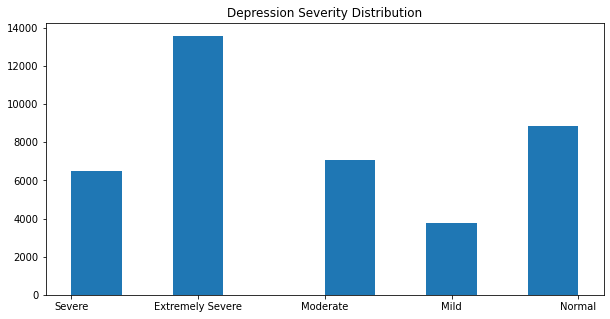

In [23]:
plt.figure(figsize=(10,5))
depression_df["severity"].hist()
plt.grid(False)
plt.title("Depression Severity Distribution")
plt.show()

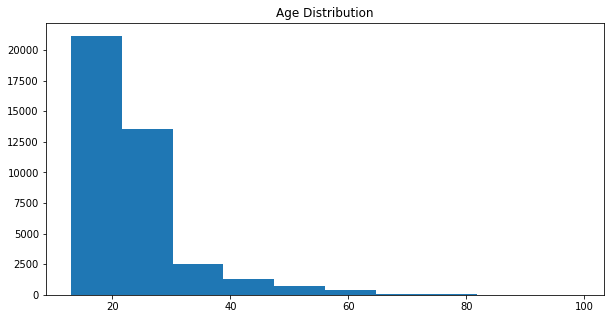

In [25]:
plt.figure(figsize=(10,5))
depression_df["age"].hist()
plt.grid(False)
plt.title("Age Distribution")
plt.show()

In [12]:
def convert_labels(label):
    classes = ["Normal", "Mild", "Moderate", "Severe", "Extremely Severe"]

    return classes.index(label)

label_encoded = depression_df["severity"].apply(lambda x: convert_labels(x))

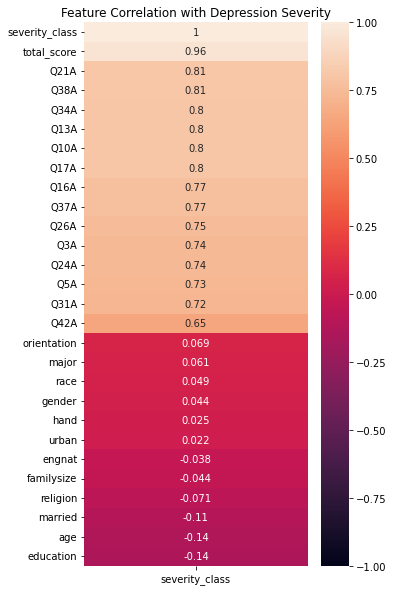

In [13]:
depression_df["severity_class"] = label_encoded

plt.figure(figsize=(5,10))
heatmap = sns.heatmap(depression_df.corr()[["severity_class"]].sort_values(by="severity_class", ascending=False), vmin=-1, vmax=1, annot=True)
heatmap.set_title("Feature Correlation with Depression Severity")

plt.show()

The heatmap shows that there exists high correlation between the scores of the individual questions and the severity of depression. This tallies with the fact that in the original DAS assessment, the severity is dependent on the sum of these scores and therefore, higher scores per question results in more severe conditions. However, when modelling, total score would not be used as a feature as this could result in redundancy with the original scores.

The demographical features, although showing lower correlation, still have potential to model the severity of depression.

### Feature Scaling and Data Splitting

In [14]:
print(depression_df.columns)

Index(['education', 'urban', 'gender', 'engnat', 'age', 'hand', 'religion',
       'orientation', 'race', 'married', 'familysize', 'major', 'Q3A', 'Q5A',
       'Q10A', 'Q13A', 'Q16A', 'Q17A', 'Q21A', 'Q24A', 'Q26A', 'Q31A', 'Q34A',
       'Q37A', 'Q38A', 'Q42A', 'total_score', 'severity', 'severity_class'],
      dtype='object')


In [15]:
np.random.seed(7)

X = depression_df.drop(["severity", "total_score", "severity_class"], axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, label_encoded, stratify=label_encoded, train_size=0.6)
scaler=MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(X_train.shape)
print(X_test.shape)

(23860, 26)
(15908, 26)


In [16]:
clf = LogisticRegression(max_iter=500)
clf.fit(X_train_scaled, y_train)

LogisticRegression(max_iter=500)

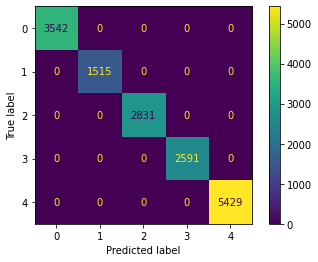

In [18]:
plot_confusion_matrix(clf, X_test_scaled, y_test)
plt.show()

In [19]:
cr = classification_report(y_test, y_pred)
print(cr)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3542
           1       1.00      1.00      1.00      1515
           2       1.00      1.00      1.00      2831
           3       1.00      1.00      1.00      2591
           4       1.00      1.00      1.00      5429

    accuracy                           1.00     15908
   macro avg       1.00      1.00      1.00     15908
weighted avg       1.00      1.00      1.00     15908



In [20]:
pipe = Pipeline([('scaler', scaler), ('log_reg', clf)])

model_date = datetime.now().strftime("%d%m%Y")
pkl_filename = f"models/dass_demography_lr_pipe_{model_date}.pkl"

with open(pkl_filename, 'wb') as file:
    pickle.dump(pipe, file)